In [1]:
from keras.models import load_model
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler

2023-05-13 20:41:39.612091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Models

In [3]:
# LSTM model
lstm = load_model('lstm_822r2.h5')

# XGBoost model
xgb = pickle.load(open('XGBoost_Latest.pkl', 'rb'))

# Random Forest model
rf = pickle.load(open('RandomForest_Latest.pkl', 'rb'))

# AdaBoost model
ada = pickle.load(open('Adaboost_Latest.pkl', 'rb'))

# VAR model
var = pickle.load(open('VAR_Latest.pkl', 'rb'))

# Load Dataset

In [4]:
# Load dataset
import pandas as pd

data = pd.read_csv("DATAA.csv")

# Merge the date and time into one column
data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Set the index to the timestamp
data = data.set_index('Timestamp')

# Drop the date and time columns
data = data.drop(['Date', 'Time'], axis=1)

# Sort the data by timestamp
data = data.sort_index()

data.head()

,No of Vehicles,Wind Speed,Visibility,Accident,Unnamed: 6,WS,Unnamed: 8,V,Unnamed: 10,A
Timestamp,,,,,,,,,,
2022-10-01 00:00:00,4523,17,16.0,3,-0.39542,-3954.2,2.4432,2443.2,-0.08643,-864.3
2022-10-01 01:00:00,3434,6,16.0,3,-0.13956,-1395.6,2.4432,2443.2,-0.08643,-864.3
2022-10-01 02:00:00,2229,7,16.0,5,-0.16282,-1628.2,2.4432,2443.2,-0.14405,-1440.5
2022-10-01 03:00:00,1583,19,16.0,4,-0.44194,-4419.4,2.4432,2443.2,-0.11524,-1152.4
2022-10-01 04:00:00,1360,15,16.0,3,-0.34890,-3489.0,2.4432,2443.2,-0.08643,-864.3


In [5]:
# LSTM only needs the timestamp and the count
lstm_data = data[['No of Vehicles']]
lstm_data.head()

,No of Vehicles
Timestamp,
2022-10-01 00:00:00,4523
2022-10-01 01:00:00,3434
2022-10-01 02:00:00,2229
2022-10-01 03:00:00,1583
2022-10-01 04:00:00,1360


In [6]:
# Drop unnamed column
model_data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Drop wind speed, visibility, and accident
model_data = model_data.drop(['Wind Speed', 'Visibility', 'Accident'], axis=1)
label_data = model_data['No of Vehicles']
model_data.head()

,No of Vehicles,WS,V,A
Timestamp,,,,
2022-10-01 00:00:00,4523,-3954.2,2443.2,-864.3
2022-10-01 01:00:00,3434,-1395.6,2443.2,-864.3
2022-10-01 02:00:00,2229,-1628.2,2443.2,-1440.5
2022-10-01 03:00:00,1583,-4419.4,2443.2,-1152.4
2022-10-01 04:00:00,1360,-3489.0,2443.2,-864.3


# Predictions

## VAR

In [7]:
y_var = var.forecast(model_data.values, steps=(len(model_data)))

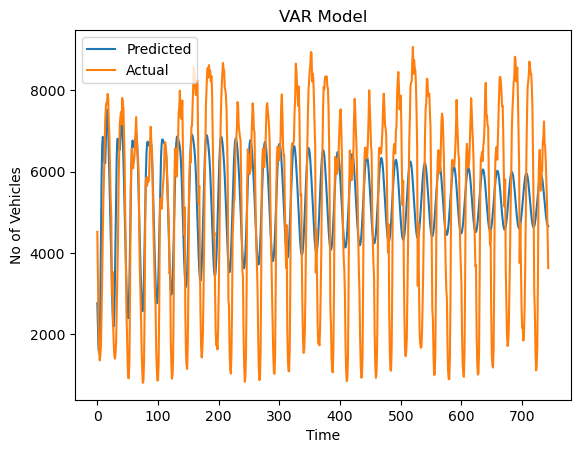

In [8]:
from matplotlib import pyplot as plt
# Plot the predictions and the actual values
plt.plot(y_var[:, 0], label='Predicted')
plt.plot(model_data['No of Vehicles'].values, label='Actual')
plt.title('VAR Model')
plt.xlabel('Time')
plt.ylabel('No of Vehicles')
plt.legend()

In [9]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(model_data['No of Vehicles'].values, y_var[:, 0]))
rmse

1881.3074441697017

# LSTM

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))

lstm_data_scaled = scaler.fit_transform(lstm_data.values.reshape(-1, 1))

In [11]:
# Create the test data
X_test = []
y_test = []
for i in range(36, len(lstm_data_scaled)):
    X_test.append(lstm_data_scaled[i-36:i, 0])
    y_test.append(lstm_data_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
# Make predictions
predictions = lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

23/23 [==============================] - 8s 117ms/step


In [14]:
mse = mean_squared_error(np.array(data['No of Vehicles'][36:]), np.array(predictions.reshape(-1)))
rmse = np.sqrt(mse)
rmse

940.0363310299774

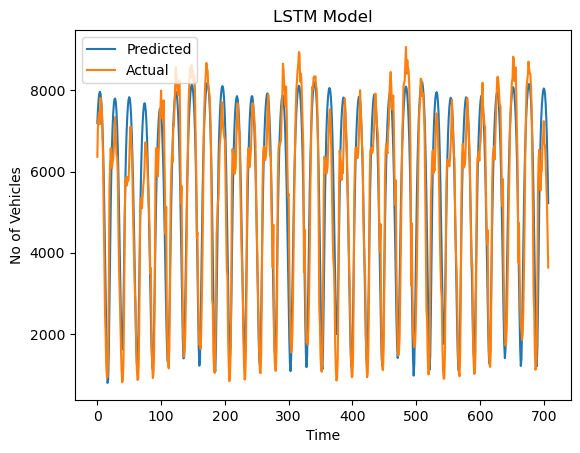

In [15]:
# Plot the predictions and the actual values
plt.plot(predictions, label='Predicted')
plt.plot(data['No of Vehicles'][36:].values, label='Actual')
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('No of Vehicles')
plt.legend()

# XGBoost Model

In [16]:
# Add lags to the data
for i in range(1,25):
    model_data["lag_{}".format(i)] = model_data['No of Vehicles'].shift(i)
    
# Create train and test set from lagged data
model_data.dropna(inplace=True)
X = model_data.drop(['No of Vehicles'], axis=1)
y = model_data['No of Vehicles']

In [17]:
X.shape, y.shape, model_data.shape

((720, 27), (720,), (720, 28))

In [18]:
pred_xgboost = xgb.predict(X)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_xgboost, y)))

215.93384422094073


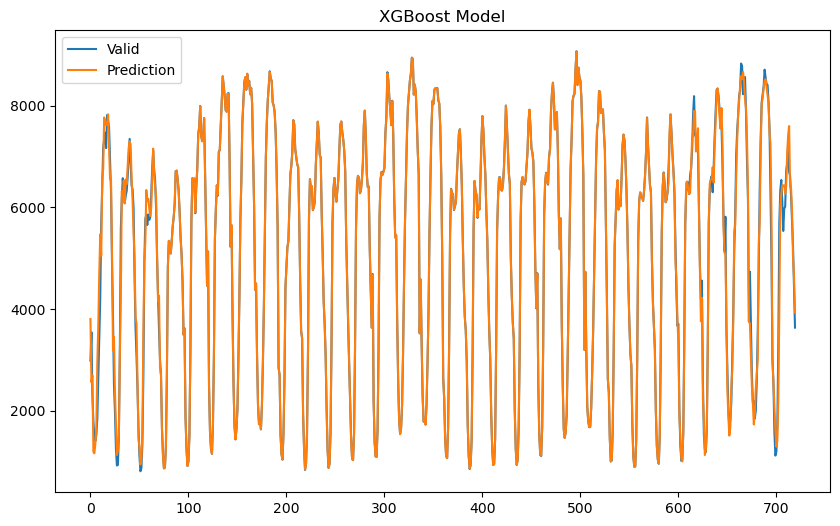

In [19]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y.values, label='Valid')
plt.plot(pred_xgboost, label='Prediction')
plt.legend(loc='best')
plt.title("XGBoost Model")
plt.show()

# Adaboost Model

In [20]:
pred_adaboost = ada.predict(X)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_adaboost, y)))

427.88701128275255


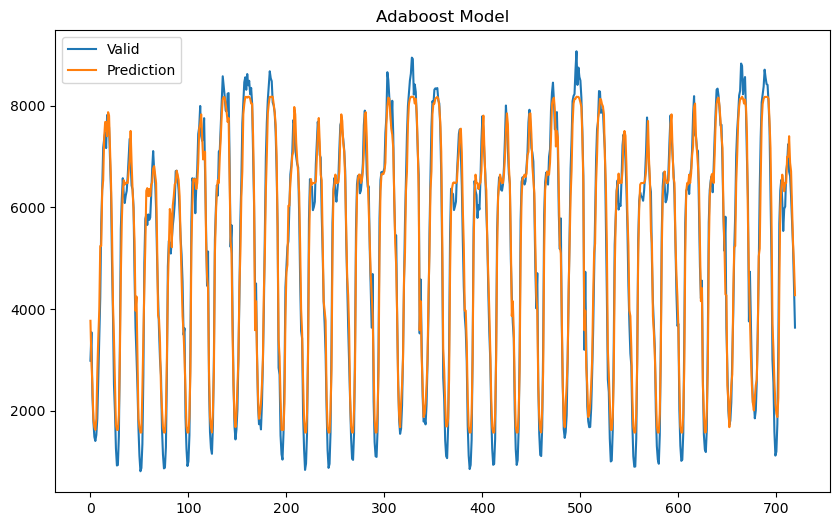

In [21]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y.values, label='Valid')
plt.plot(pred_adaboost, label='Prediction')
plt.legend(loc='best')
plt.title("Adaboost Model")
plt.show()

# Random Forest Model

In [22]:
pred_rf = rf.predict(X)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_rf, y)))

186.6852814472201


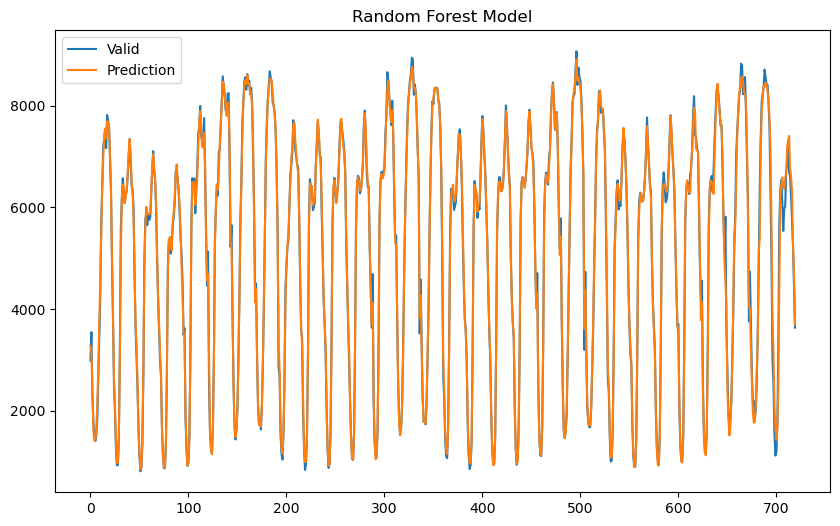

In [23]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y.values, label='Valid')
plt.plot(pred_rf, label='Prediction')
plt.legend(loc='best')
plt.title("Random Forest Model")
plt.show()

# Combine Multivariate Models with LSTM

## LSTM + XGBoost

In [28]:
# LSTM used 36 lags - so, data taken = 744-36 = 708
# Multivariates used 25 lags; i.e, 24 data skipped. So, data taken = 744-24 = 720
predictions.shape, pred_xgboost[12:].shape

((708, 1), (708,))

In [29]:
best_value_xgb = 999999
best_weight_xgb = 0

for i in range(1, 100):
    y_pred = (i/100)*predictions.flatten() + (1-i/100)*pred_xgboost[12:]
    rmse = np.sqrt(mean_squared_error(label_data[36:], y_pred))
    print('RMSE for weight %.3f is %.3f' % (i/100, rmse))
    # Save the best weight
    if rmse < best_value_xgb:
        best_value_xgb = rmse
        best_weight_xgb = i/100

RMSE for weight 0.010 is 190.066
RMSE for weight 0.020 is 191.340
RMSE for weight 0.030 is 193.034
RMSE for weight 0.040 is 195.135
RMSE for weight 0.050 is 197.632
RMSE for weight 0.060 is 200.508
RMSE for weight 0.070 is 203.749
RMSE for weight 0.080 is 207.337
RMSE for weight 0.090 is 211.254
RMSE for weight 0.100 is 215.483
RMSE for weight 0.110 is 220.005
RMSE for weight 0.120 is 224.803
RMSE for weight 0.130 is 229.859
RMSE for weight 0.140 is 235.157
RMSE for weight 0.150 is 240.681
RMSE for weight 0.160 is 246.415
RMSE for weight 0.170 is 252.346
RMSE for weight 0.180 is 258.460
RMSE for weight 0.190 is 264.743
RMSE for weight 0.200 is 271.185
RMSE for weight 0.210 is 277.775
RMSE for weight 0.220 is 284.501
RMSE for weight 0.230 is 291.355
RMSE for weight 0.240 is 298.327
RMSE for weight 0.250 is 305.410
RMSE for weight 0.260 is 312.597
RMSE for weight 0.270 is 319.879
RMSE for weight 0.280 is 327.252
RMSE for weight 0.290 is 334.708
RMSE for weight 0.300 is 342.242
RMSE for w

In [36]:
best_value_xgb, best_weight_xgb, (best_weight_xgb*predictions.flatten() + (1-best_weight_xgb)*pred_xgboost[12:]).shape

(190.06563272770285, 0.01, (708,))

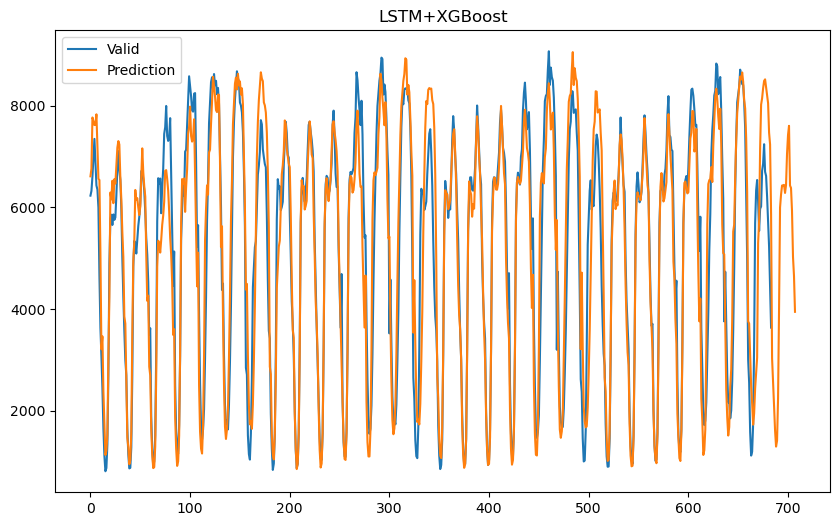

In [39]:
y_pred = best_weight_xgb*predictions.flatten() + (1-best_weight_xgb)*pred_xgboost[12:]
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y[36:].values, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.legend(loc='best')
plt.title("LSTM+XGBoost")
plt.show()

## LSTM + Adaboost

In [40]:
best_value_ada = 999999
best_weight_ada = 0

for i in range(1, 100):
    y_pred = (i/100)*predictions.flatten() + (1-i/100)*pred_adaboost[12:]
    rmse = np.sqrt(mean_squared_error(label_data[36:], y_pred))
    print('RMSE for weight %.3f is %.3f' % (i/100, rmse))
    # Save the best weight
    if rmse < best_value_ada:
        best_value_ada = rmse
        best_weight_ada = i/100

RMSE for weight 0.010 is 425.919
RMSE for weight 0.020 is 427.467
RMSE for weight 0.030 is 429.147
RMSE for weight 0.040 is 430.957
RMSE for weight 0.050 is 432.896
RMSE for weight 0.060 is 434.962
RMSE for weight 0.070 is 437.152
RMSE for weight 0.080 is 439.466
RMSE for weight 0.090 is 441.901
RMSE for weight 0.100 is 444.455
RMSE for weight 0.110 is 447.126
RMSE for weight 0.120 is 449.912
RMSE for weight 0.130 is 452.812
RMSE for weight 0.140 is 455.822
RMSE for weight 0.150 is 458.940
RMSE for weight 0.160 is 462.165
RMSE for weight 0.170 is 465.495
RMSE for weight 0.180 is 468.926
RMSE for weight 0.190 is 472.457
RMSE for weight 0.200 is 476.085
RMSE for weight 0.210 is 479.809
RMSE for weight 0.220 is 483.626
RMSE for weight 0.230 is 487.534
RMSE for weight 0.240 is 491.531
RMSE for weight 0.250 is 495.614
RMSE for weight 0.260 is 499.782
RMSE for weight 0.270 is 504.032
RMSE for weight 0.280 is 508.363
RMSE for weight 0.290 is 512.771
RMSE for weight 0.300 is 517.256
RMSE for w

In [41]:
best_value_ada, best_weight_ada

(425.9185069355803, 0.01)

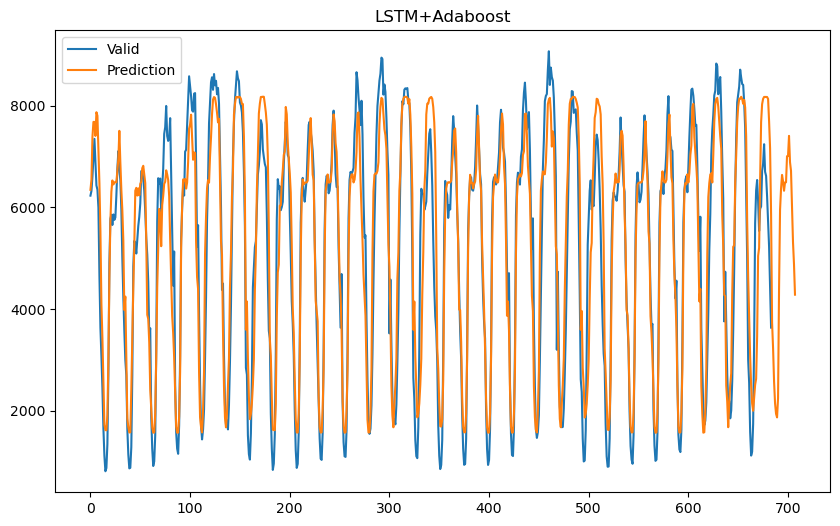

In [44]:
y_pred = best_weight_ada*predictions.flatten() + (1-best_weight_ada)*pred_adaboost[12:]
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y[36:].values, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.legend(loc='best')
plt.title("LSTM+Adaboost")
plt.show()

## LSTM + Random Forest

In [45]:
best_value_rf = 999999
best_weight_rf = 0

for i in range(1, 100):
    y_pred = (i/100)*predictions.flatten() + (1-i/100)*pred_rf[12:]
    rmse = np.sqrt(mean_squared_error(label_data[36:], y_pred))
    print('RMSE for weight %.3f is %.3f' % (i/100, rmse))
    # Save the best weight
    if rmse < best_value_rf:
        best_value_rf = rmse
        best_weight_rf = i/100

RMSE for weight 0.010 is 188.462
RMSE for weight 0.020 is 191.609
RMSE for weight 0.030 is 195.091
RMSE for weight 0.040 is 198.890
RMSE for weight 0.050 is 202.989
RMSE for weight 0.060 is 207.370
RMSE for weight 0.070 is 212.015
RMSE for weight 0.080 is 216.908
RMSE for weight 0.090 is 222.032
RMSE for weight 0.100 is 227.371
RMSE for weight 0.110 is 232.911
RMSE for weight 0.120 is 238.637
RMSE for weight 0.130 is 244.537
RMSE for weight 0.140 is 250.599
RMSE for weight 0.150 is 256.810
RMSE for weight 0.160 is 263.161
RMSE for weight 0.170 is 269.640
RMSE for weight 0.180 is 276.241
RMSE for weight 0.190 is 282.953
RMSE for weight 0.200 is 289.769
RMSE for weight 0.210 is 296.682
RMSE for weight 0.220 is 303.686
RMSE for weight 0.230 is 310.773
RMSE for weight 0.240 is 317.939
RMSE for weight 0.250 is 325.179
RMSE for weight 0.260 is 332.487
RMSE for weight 0.270 is 339.860
RMSE for weight 0.280 is 347.292
RMSE for weight 0.290 is 354.781
RMSE for weight 0.300 is 362.323
RMSE for w

In [46]:
best_value_rf, best_weight_rf

(188.46198101880114, 0.01)

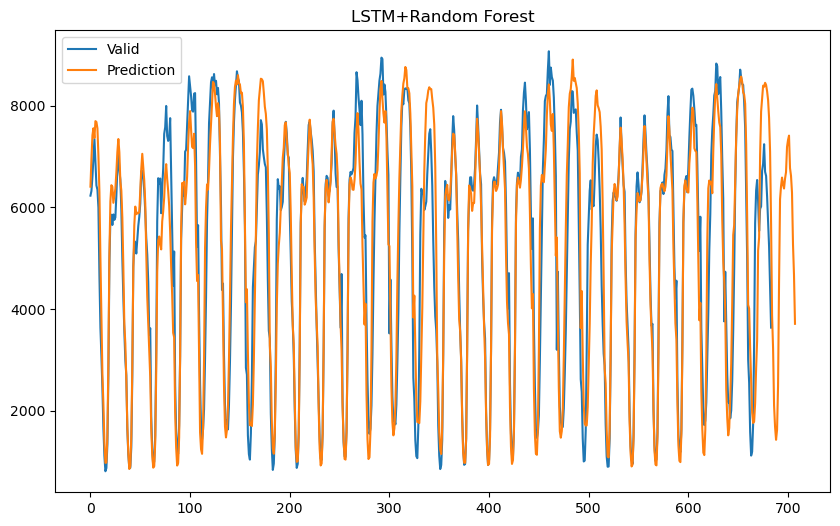

In [47]:
y_pred = best_weight_rf*predictions.flatten() + (1-best_weight_rf)*pred_rf[12:]
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y[36:].values, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.legend(loc='best')
plt.title("LSTM+Random Forest")
plt.show()